In [83]:
import json
import os
import collections
import seaborn as sns

In [84]:
%matplotlib inline
import matplotlib.pyplot as plt

In [161]:
files = os.listdir('user_data/')
covered = set()
count = 0
r1, r2, r3 = [], [], []
for name in files:
    if '.json' not in name: continue
    # print(name)
    count += 1
    with open('user_data/' + name, 'r') as f:
        d = json.load(f)
        for item in d:
            if 'rank_result' in item:
                covered.add(item['rank_result'][0].split('/')[1].split('_')[0])
                t = [i.split('/')[0] for i in item['rank_result']]
                r1.append(t[0])
                r2.append(t[1])
                r3.append(t[2])
print('number of subjects:', count)
print('number of covered images:', len(covered))
print('coverage rate:', len(covered) / 3000)

number of subjects: 21
number of covered images: 1549
coverage rate: 0.5163333333333333


In [162]:
r1 = collections.Counter(r1)
r2 = collections.Counter(r2)
r3 = collections.Counter(r3)

In [163]:
r1

Counter({'ce': 213, 'gl': 194, 'ours': 1693})

In [158]:
for key in r1:
    print(key, r1[key] + r2[key] + r3[key])

ours 1900
gl 1900
ce 1900


<Container object of 3 artists>

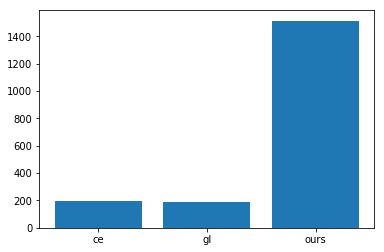

In [159]:
t = dict(r1)
plt.bar(x=list(t.keys()), height=list(t.values()))